In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
import scipy.stats
import tensorflow as tf

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Load NIH data
df = pd.read_csv('/data/Data_Entry_2017.csv')
df = df.drop("Unnamed: 11", axis=1)
df.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
63008,00015573_001.png,Infiltration,1,15573,22,M,PA,2790,2932,0.143,0.143
9735,00002524_014.png,No Finding,14,2524,51,M,PA,2048,2500,0.171,0.171
64475,00015912_000.png,No Finding,0,15912,33,F,PA,2992,2991,0.143,0.143
72191,00017762_011.png,No Finding,11,17762,14,F,PA,2728,2360,0.143,0.143
9250,00002412_004.png,Consolidation|Nodule|Pneumothorax,4,2412,64,M,PA,2698,2681,0.143,0.143


## Age

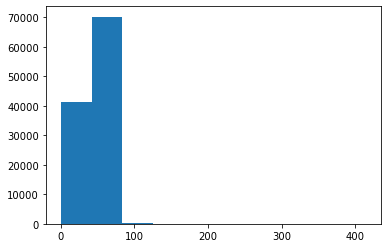

In [3]:
plt.hist(df["Patient Age"])
plt.show()

Looks like there are bogus ages. Some of our patients are over 400 years old!

In [4]:
bogus_ages_mask = df["Patient Age"]>400
df[bogus_ages_mask]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
20852,00005567_000.png,Effusion|Pneumonia,0,5567,412,M,AP,3056,2544,0.139,0.139
46965,00011973_002.png,Edema,2,11973,414,M,AP,3056,2544,0.139,0.139
84810,00020900_002.png,No Finding,2,20900,411,M,AP,3056,2544,0.139,0.139
85404,00021047_002.png,Mass|Pleural_Thickening,2,21047,412,M,AP,3056,2544,0.139,0.139
86264,00021275_003.png,No Finding,3,21275,413,F,AP,3056,2544,0.139,0.139
91369,00022811_000.png,No Finding,0,22811,412,M,PA,3056,2544,0.139,0.139


Let's get rid of those...

In [5]:
df.drop(index = df[bogus_ages_mask].index, inplace=True)

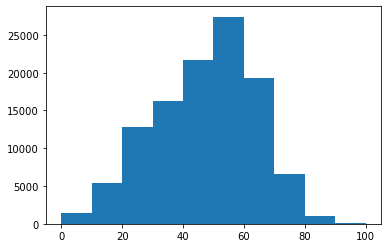

In [6]:
plt.hist(df["Patient Age"], range=(0,100), bins=10)
plt.show()

## Gender

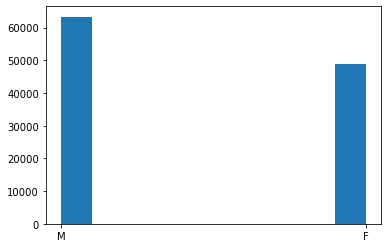

In [7]:
df["Patient Gender"].hist(grid=False)
plt.show()

Hmm there are significantly more males here:

In [8]:
num_females = sum(df["Patient Gender"]=="F")
print("Chance of getting at least this amount of gender gap if genders were equally likely:",
      scipy.stats.binom.cdf(num_females, n=len(df), p=0.5))

Chance of getting at least this amount of gender gap if genders were equally likely: 0.0


Interesting, but there's still enough of each gender to not limit the applicability of a learned model, I think.

## X-ray Orientation

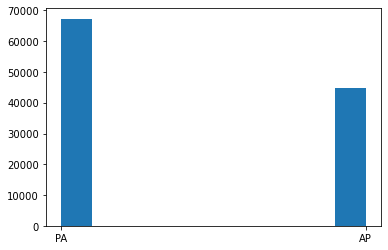

In [9]:
df["View Position"].hist(grid=False)
plt.show()

There's a good mix of both posterior-to-anterior and anterior-to-posterior X-ray orientations. There are more PA, which is to be expected since that is the preferred orientation. AP is done when a patient is bed-ridden and lying on their back.

## Convert Finding Labels to Vectors

In [10]:
finding_names = list(set(l for findings in df["Finding Labels"] for l in findings.split('|')))
print("Finding labels that occur in the data set:\n\n\t"+'\n\t'.join(finding_names))

Finding labels that occur in the data set:

	Nodule
	Pneumothorax
	Mass
	Cardiomegaly
	Atelectasis
	Emphysema
	Fibrosis
	Pleural_Thickening
	Consolidation
	No Finding
	Hernia
	Edema
	Pneumonia
	Infiltration
	Effusion


In [11]:
for finding_name in finding_names:
    df[finding_name] = df["Finding Labels"].apply(lambda x : int(finding_name in x.split('|')))

df.sample(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Pleural_Thickening,Consolidation,No Finding,Hernia,Edema,Pneumonia,Infiltration,Effusion
108097,00029259_002.png,Infiltration,2,29259,34,F,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,0,1,0
96431,00025382_005.png,Infiltration,5,25382,58,F,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,0,1,0
69360,00017116_007.png,No Finding,7,17116,44,F,AP,2500,2048,0.168,...,0,0,0,0,1,0,0,0,0,0
81130,00019924_022.png,No Finding,22,19924,56,F,AP,3056,2544,0.139,...,0,0,0,0,1,0,0,0,0,0
15321,00004006_042.png,No Finding,42,4006,34,F,AP,2500,2048,0.168,...,0,0,0,0,1,0,0,0,0,0
92050,00022977_001.png,No Finding,1,22977,43,M,AP,3056,2544,0.139,...,0,0,0,0,1,0,0,0,0,0
74131,00018232_001.png,No Finding,1,18232,43,F,PA,2992,2991,0.143,...,0,0,0,0,1,0,0,0,0,0
110643,00030152_003.png,Infiltration,3,30152,16,F,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,0,1,0
35088,00009256_005.png,Atelectasis,5,9256,55,F,AP,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
56503,00014056_000.png,No Finding,0,14056,54,M,AP,2500,2048,0.168,...,0,0,0,0,1,0,0,0,0,0


## Disease Finding Stats

In [12]:
total = len(df)
print("Pateints with no finding: {}/{} = {}".format(sum(df["No Finding"]),total,sum(df["No Finding"])/total))
print("Pateints with pneumonia: {}/{} = {}".format(sum(df["Pneumonia"]),total,sum(df["Pneumonia"])/total))

Pateints with no finding: 60358/112114 = 0.5383627379274667
Pateints with pneumonia: 1430/112114 = 0.012754874502738284


Among the patients with penumonia, the AP orientation actually becomes more common:

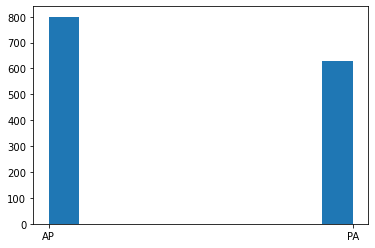

In [13]:
df[df['Pneumonia']==1]["View Position"].hist(grid=False)
plt.show()

I guess patients who are suspected to have pneumonia tend more to be bid-ridden?

Let's now look at amount of each finding, with and without pneumonia:

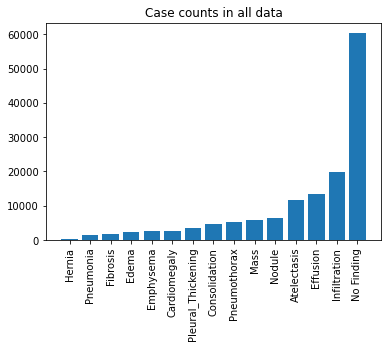

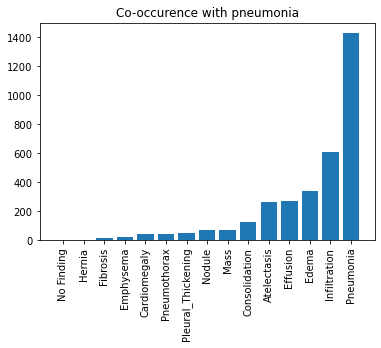

In [14]:
finding_counts_all = {fn:sum(df[fn]) for fn in finding_names}
finding_counts_pneumonia = {fn:sum(df[df["Pneumonia"]==1][fn]) for fn in finding_names}
finding_names.sort(key = lambda fn : finding_counts_all[fn])
plt.bar(x=range(0,len(finding_counts_all)),height=[finding_counts_all[fn] for fn in finding_names],tick_label=finding_names)
plt.xticks(rotation="vertical")
plt.title("Case counts in all data")
plt.show()
finding_names.sort(key = lambda fn : finding_counts_pneumonia[fn])
plt.bar(x=range(0,len(finding_counts_pneumonia)),height=[finding_counts_pneumonia[fn] for fn in finding_names],tick_label=finding_names)
plt.xticks(rotation="vertical")
plt.title("Co-occurence with pneumonia")
plt.show()

Correlation coefficients of other findings with pneumonia:

In [15]:
df[finding_names].corr()["Pneumonia"].sort_values(ascending=False)

Pneumonia             1.000000
Edema                 0.174111
Infiltration          0.073080
Atelectasis           0.029946
Consolidation         0.025259
Effusion              0.024116
Cardiomegaly          0.002861
Pleural_Thickening    0.002247
Hernia                0.000185
Mass                 -0.000983
Nodule               -0.003702
Emphysema            -0.004879
Fibrosis             -0.006861
Pneumothorax         -0.009971
No Finding           -0.122748
Name: Pneumonia, dtype: float64

The correlation coefficients and the co-occurence counts seem to agree in telling us that pneumonia labels tend to occur alongside edema, infiltration, atelectasis, consolidation, and effusion.

The most correlated disease label to pneumonia is edema.

The disease label that co-occurs with pneomonia the most is infiltration.

In [16]:
finding_names_diseases = [fn for fn in finding_names if fn!="No Finding"]
df["number of diseases"] = df[finding_names_diseases].sum(axis=1)

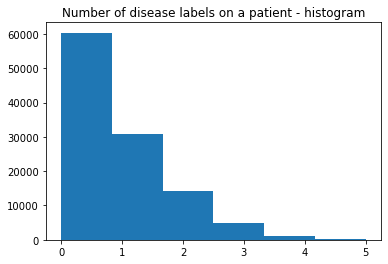

In [17]:
df["number of diseases"].hist(grid=False, range=(0,5), bins=6)
plt.title("Number of disease labels on a patient - histogram")
plt.show()

## Looking at individual images

Run the following cell many times to see various images and intensity distributions.

I chose to look at three different pixel intensity stats: the mode in the foreground, the sum of pixel values in the foreground, and the area of the foreground. Even together they don't look too promising for the purpose of disease label classification.

No Finding


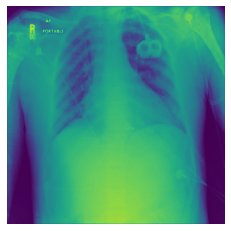

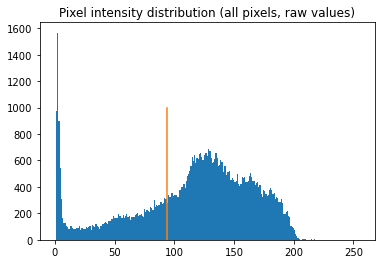

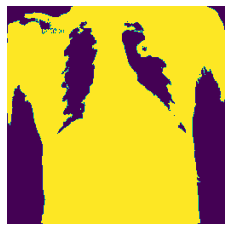

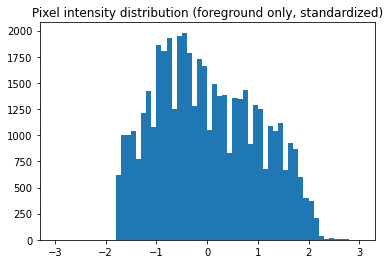

Foreground pixel values mode: 129
Sum of pixel values in the foreground: 6706129
Area of foreground: 47138


In [18]:
# Choose a random row, load the image, and show it
row = df.sample(1).iloc[0]
paths = glob("/data/images_*/images/" + row["Image Index"])
assert(len(paths)==1)
path = paths[0]
img = tf.keras.preprocessing.image.load_img(path, color_mode="grayscale")
img_small = img.copy()
img_small.thumbnail((256,256))
print(row["Finding Labels"])
plt.imshow(img_small)
plt.axis('off')
plt.show()

# get the pixel values
pixel_vals = np.array(list(img_small.getdata())) # flattened form
pixel_vals_2d = pixel_vals.reshape(img_small.width,img_small.height)

# function to apply otsu's method
def otsu_threshold(pixel_vals):
    val_counts = np.bincount(pixel_vals, minlength=256) # e.g. val_counts[145] is the number of pixels valued at 145
    threshold_variance_pairs = []
    for threshold in range(0,255):
        below = pixel_vals[pixel_vals <= threshold]
        above = pixel_vals[pixel_vals >  threshold]
        if below.size==0 or above.size==0:
            continue
        w1 = val_counts[:(threshold+1)].sum()
        w2 = val_counts[(threshold+1):].sum()
        weighted_sum_of_var = w1*below.var() + w2*above.var()
        if np.isnan(weighted_sum_of_var):
            continue
        threshold_variance_pairs.append((threshold,weighted_sum_of_var))
    return min(threshold_variance_pairs, key=lambda x:x[1])[0]

# show intensity histogram and otsu threshold
threshold = otsu_threshold(pixel_vals)
plt.hist(pixel_vals, range=(0,255),bins=256)
plt.plot([threshold, threshold], [0,1000])
plt.title("Pixel intensity distribution (all pixels, raw values)")
plt.show()

# show the "foreground" chosen by otsu's method
plt.imshow(pixel_vals_2d >= threshold)
plt.axis('off')
plt.show()

# show intensity histogram for only "foreground" pixels
foreground_pixel_vals = pixel_vals[pixel_vals>= threshold]
standardized_pixel_vals = (foreground_pixel_vals - foreground_pixel_vals.mean())/foreground_pixel_vals.std()
plt.hist(standardized_pixel_vals, range=(-3,3),bins=6*10)
plt.title("Pixel intensity distribution (foreground only, standardized)")
plt.show()

# print some stats
mode = scipy.stats.mode(foreground_pixel_vals)[0][0]
print("Foreground pixel values mode:", mode)
print("Sum of pixel values in the foreground:", foreground_pixel_vals.sum())
print("Area of foreground:", foreground_pixel_vals.shape[0])

## Pixel Intensity Stats by Disease

In [19]:
# function to gather the three stats from above given a row in the data
# much is copied from the exploration above
def gather_stats(row):
    paths = glob("/data/images_*/images/" + row["Image Index"])
    assert(len(paths)==1)
    path = paths[0]
    img = tf.keras.preprocessing.image.load_img(path, color_mode="grayscale")
    img_small = img.copy()
    img_small.thumbnail((64,64))

    pixel_vals = np.array(list(img_small.getdata())) # flattened form
    pixel_vals_2d = pixel_vals.reshape(img_small.width,img_small.height)

    threshold = otsu_threshold(pixel_vals)

    # show intensity histogram for only "foreground" pixels
    foreground_pixel_vals = pixel_vals[pixel_vals>= threshold]

    mode = scipy.stats.mode(foreground_pixel_vals)[0][0]
    foreground_sum = foreground_pixel_vals.sum()
    foreground_area = foreground_pixel_vals.shape[0]

    return mode, foreground_sum, foreground_area

In [48]:
# Take a sample to work with
df_sample = df.sample(1000)

In [49]:
# This will take a little while to run. Decrease the number of samples in the cell above if you want.
pixel_intensity_stats = df_sample.apply(gather_stats, axis=1)
df_sample["pixel mode"] = pixel_intensity_stats.apply(lambda x : x[0])
df_sample["pixel sum"] = pixel_intensity_stats.apply(lambda x : x[1])
df_sample["pixel area"] = pixel_intensity_stats.apply(lambda x : x[2])
df_sample.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,No Finding,Hernia,Edema,Pneumonia,Infiltration,Effusion,number of diseases,pixel mode,pixel sum,pixel area
12767,00003354_003.png,No Finding,3,3354,20,F,PA,2980,2576,0.143,...,1,0,0,0,0,0,0,104,251819,1620
92190,00023026_009.png,Infiltration,9,23026,30,F,AP,3056,2544,0.139,...,0,0,0,0,1,0,1,127,305417,2349
51176,00012931_018.png,No Finding,18,12931,47,F,AP,2500,2048,0.168,...,1,0,0,0,0,0,0,157,413842,3122
10298,00002670_000.png,No Finding,0,2670,59,F,PA,2048,2500,0.171,...,1,0,0,0,0,0,0,191,588264,3367
43748,00011269_005.png,Consolidation,5,11269,41,M,PA,2992,2991,0.143,...,0,0,0,0,0,0,1,170,302620,2146


Let's see if any of the pixel stats look like they can be related to the presence of pneuomonia...

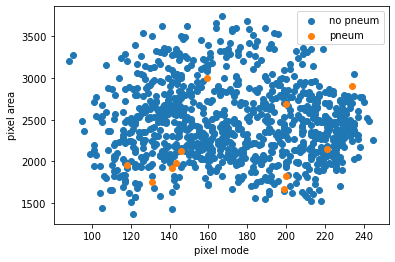

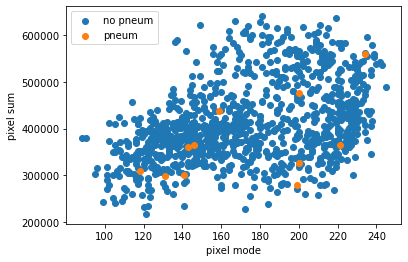

In [50]:
pneumonia_mask = df_sample['Pneumonia']==1
plt.scatter(df_sample['pixel mode'][~pneumonia_mask], df_sample['pixel area'][~pneumonia_mask], label='no pneum')
plt.scatter(df_sample['pixel mode'][pneumonia_mask], df_sample['pixel area'][pneumonia_mask], label='pneum')
plt.xlabel('pixel mode')
plt.ylabel('pixel area')
plt.legend()
plt.show()

plt.scatter(df_sample['pixel mode'][~pneumonia_mask], df_sample['pixel sum'][~pneumonia_mask], label='no pneum')
plt.scatter(df_sample['pixel mode'][pneumonia_mask], df_sample['pixel sum'][pneumonia_mask], label='pneum')
plt.xlabel('pixel mode')
plt.ylabel('pixel sum')
plt.legend()
plt.show()

At least by eye, there does not seem to be any structure to this data that can select the pneumonia cases. The pixel intensity stats I came up with are not helpful.